<a href="https://www.kaggle.com/code/prikarsartam/adv-ml-assignment-underprogress?scriptVersionId=112899974" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [77]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 6376), started 0:01:20 ago. (Use '!kill 6376' to kill it.)

In [2]:
from pylab import *
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
from numpy import random
import cv2 as cv

In [3]:
training_path = "/kaggle/input/landscape-classifier/Landscape_classifier_01/training/"
testing_path = "/kaggle/input/landscape-classifier/Landscape_classifier_01/testing"
prediction_path = "/kaggle/input/landscape-classifier/Landscape_classifier_01/prediction/"

In [4]:
path = f"/kaggle/input/landscape-classifier/Landscape_classifier_01"
dir_list = os.listdir(path)  
# print the list 
print(dir_list)

['training', 'prediction', 'testing']


#### 

In [10]:
def visualize(K,row_num, col_num):    # An image visualization function
    image_store = []
    img_loc = []
    for i in range(0,row_num*col_num):
        image_store.append(K+os.listdir(K)[random.randint(0,row_num*col_num)])  # randomly show row*col number of images
        
    for item in image_store:
        img_loc.append(cv.imread(item))
    f, axarr = plt.subplots(row_num, col_num,figsize=(14,14))
    f.tight_layout()
    f.suptitle("Images in Prediction dataset",size=18,fontweight="bold")
    f.subplots_adjust(top=0.95)
    
    for i in range(0, row_num*col_num):
        axarr[int(i/col_num),int(i%col_num)].imshow(img_loc[i])

## Note : Unlike training and testing folders, where 6 classes of images are seperated into folders, the prediction folder has just scrambled images with no labels, which will be later used to validate the model and tune our hyperparameters

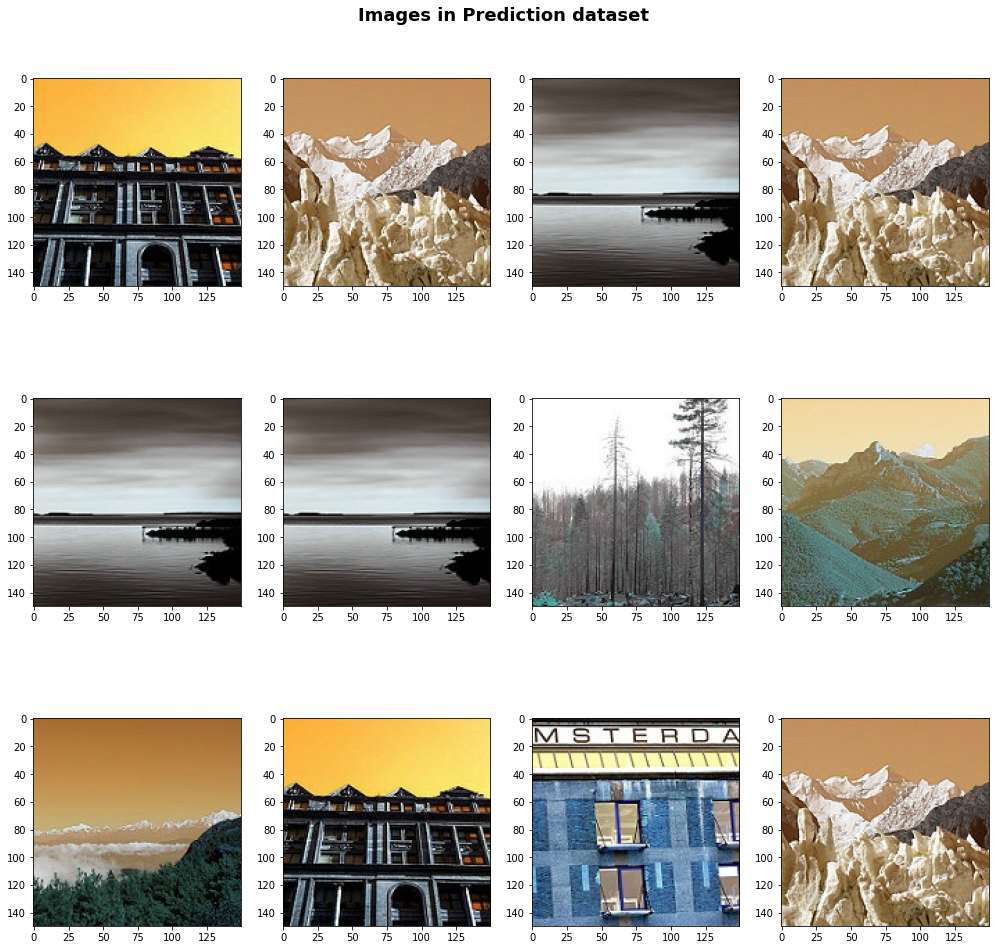

In [13]:
visualize(prediction_path, 3, 4)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # for auto-labelling the datasets based on the folders they are in
from tensorflow.keras.preprocessing import image

In [15]:
# pick randomly images from prediction dataset to obtain knowledge about the sizes of the images

image0 = cv.imread(prediction_path+os.listdir(prediction_path)[random.randint(0,len(os.listdir(prediction_path)))])
image0.shape

# which says all images are RGB and 150*150

(150, 150, 3)

In [35]:
train = ImageDataGenerator(rescale=1.0/255.0)
validation = ImageDataGenerator(rescale=1.0/255.0)


training_dataset = train.flow_from_directory(training_path,        # although all the images are of equal size 150*150 - we can still scale it down to 100*100 due to general practice
											target_size=(100,100),
											batch_size = 10,
											class_mode='categorical')

validation_dataset = validation.flow_from_directory(testing_path,
											target_size=(100,100),
											batch_size = 10,
											class_mode='categorical')
											

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [17]:
training_dataset.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [80]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:


model = keras.models.Sequential([
    layers.Flatten(input_shape=(100,100,3)),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(6),
    #layers.Dense(6, activation='softmax')
])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               3000100   
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 606       
Total params: 3,010,806
Trainable params: 3,010,806
Non-trainable params: 0
_________________________________________________________________
None


## Unregularized FeedForward Neural Network

In [84]:
inputs = layers.Input(shape=(100,100,3))
flatten = layers.Flatten()
dense1 = layers.Dense(100, activation='relu')
dense2 = layers.Dense(100, activation='relu')
dense_out = layers.Dense(6, activation='softmax')

# dense3 = layers.Dense(6, activation='softmax')
x = flatten(inputs)
x = dense1(x)
x = dense2(x)
outputs = dense_out(x)

model = keras.Model(inputs = inputs, outputs = outputs, name='prikarsartams_feedforward_image_classifier')

print(model.summary())

Model: "prikarsartams_feedforward_image_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 100)               3000100   
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 606       
Total params: 3,010,806
Trainable params: 3,010,806
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

# 'accuracy', - in metric[] 
# ,keras.metrics.SparseCategoricalAccuracy() - in metric[]

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [88]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

history = model.fit(training_dataset, validation_data = validation_dataset, epochs=150, verbose=1, callbacks=[])

Epoch 1/150
1404/1404 [==============================] - 27s 19ms/step - loss: 1.2831 - accuracy: 0.4997 - val_loss: 1.4159 - val_accuracy: 0.4363
Epoch 2/150
1404/1404 [==============================] - 27s 19ms/step - loss: 1.2490 - accuracy: 0.5110 - val_loss: 1.3665 - val_accuracy: 0.4083
Epoch 3/150
1404/1404 [==============================] - 27s 19ms/step - loss: 1.2218 - accuracy: 0.5195 - val_loss: 1.3179 - val_accuracy: 0.4873
Epoch 4/150
1404/1404 [==============================] - 27s 19ms/step - loss: 1.2048 - accuracy: 0.5274 - val_loss: 1.2582 - val_accuracy: 0.5130
Epoch 5/150
1404/1404 [==============================] - 27s 20ms/step - loss: 1.1688 - accuracy: 0.5485 - val_loss: 1.3526 - val_accuracy: 0.4677
Epoch 6/150
1404/1404 [==============================] - 27s 19ms/step - loss: 1.1590 - accuracy: 0.5515 - val_loss: 1.2428 - val_accuracy: 0.5177
Epoch 7/150
1404/1404 [==============================] - 27s 19ms/step - loss: 1.1311 - accuracy: 0.5646 - val_loss: 1

In [89]:
for items in history.history:
    print(items)

# for items in history.history['loss']:
#     print(items)

loss
accuracy
val_loss
val_accuracy


#### Unregularized Accuracy and Loss for Training and Validation datasets

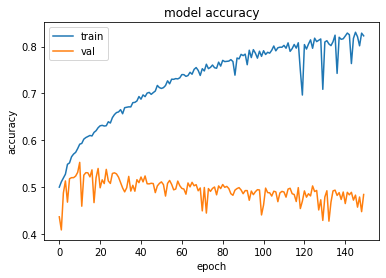

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

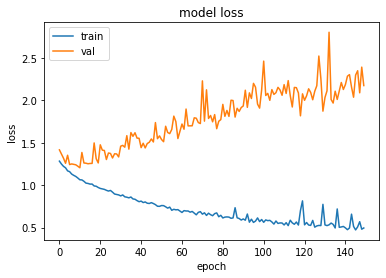

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## A new Regularized Model

In [100]:
tf.random.set_seed(0)

inputs = layers.Input(shape=(100,100,3))
flatten = layers.Flatten()
dense1 = layers.Dense(100, activation='relu',  kernel_regularizer='l2')   # Implementing L2 Regularization (eventual_squared-weight-decay during training)
dense2 = layers.Dense(100, activation='relu',  kernel_regularizer='l2')
dense_out = layers.Dense(6, activation='softmax')
drop_out = layers.Dropout(0.42)

# dense3 = layers.Dense(6, activation='softmax')
x = flatten(inputs)
x = dense1(x)
x = drop_out(x)         # Implementing random dropout of 42% of the weights
x = dense2(x)
x = drop_out(x)
outputs = dense_out(x)

model_1 = keras.Model(inputs = inputs, outputs = outputs, name='prikarsartams_regularised_feedforward_image_classifier')

print(model_1.summary())

Model: "prikarsartams_regularised_feedforward_image_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 30000)        0           input_12[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 100)          3000100     flatten_14[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100)          0           dense_64[0][0]                   
                                             

In [101]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

# 'accuracy', - in metric[] 
# ,keras.metrics.SparseCategoricalAccuracy() - in metric[]

model_1.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adagrad(              # Using Adaptive Gradient Algorithm - Adagrad 
                             learning_rate=0.001,
                             initial_accumulator_value=0.1,
                             epsilon=1e-07,
                             name="Adagrad"),
                metrics=['accuracy'])

### The difference and Regularizations implemented in this run:

- the optimized which previously was ADAM (Adaptive Moment Estimation), and now is AdaGrad (Adaptive Gradient Algorithm)
- L2 Regularization (eventual squared-weight-decay during training)
- dropout (decreasing capacity of complexity of the model)
- Early stopping implemented (If the validation_loss doesn't improve for 5 epochs (patience_value), then stop training)

In [ ]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)  # Earlystop Implementation 

history_1 = model_1.fit(training_dataset, validation_data = validation_dataset, epochs=150, verbose=1, callbacks=[early_stop])   # calling Earlystop as callback during the break in between the epochs


print("\n\n")
print("Early stopping enabled the training to stop at : "+str(len(history.history['loss']))+"-th epoch")

Epoch 1/150
1404/1404 [==============================] - 28s 20ms/step - loss: 4.5013 - accuracy: 0.2299 - val_loss: 4.1924 - val_accuracy: 0.3793
Epoch 2/150
1404/1404 [==============================] - 27s 19ms/step - loss: 3.9839 - accuracy: 0.2891 - val_loss: 3.6992 - val_accuracy: 0.4610
Epoch 3/150
1404/1404 [==============================] - 27s 19ms/step - loss: 3.5940 - accuracy: 0.3280 - val_loss: 3.3272 - val_accuracy: 0.4680
Epoch 4/150
1404/1404 [==============================] - 27s 19ms/step - loss: 3.2703 - accuracy: 0.3618 - val_loss: 3.0454 - val_accuracy: 0.4667
Epoch 5/150
1404/1404 [==============================] - 27s 19ms/step - loss: 3.0126 - accuracy: 0.3762 - val_loss: 2.8050 - val_accuracy: 0.4757
Epoch 6/150
1404/1404 [==============================] - 28s 20ms/step - loss: 2.7907 - accuracy: 0.3910 - val_loss: 2.5998 - val_accuracy: 0.4890
Epoch 7/150
1404/1404 [==============================] - 27s 19ms/step - loss: 2.5935 - accuracy: 0.4101 - val_loss: 2

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()